In [2]:
import os
from collections import Counter, defaultdict

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import probscale
import itertools
import csv

from pathlib import Path

plt.rcParams.update({'font.size': 12, 'figure.autolayout': True})

class Result:
    def __init__(self, path):
        self.path = Path("results").joinpath(path, "flamestream")
    
    def lat_data(self):
        with open(self.path.joinpath("latency/lat.data"), 'r') as file:
            return list(map(int, file.read().split(", ")))
    
    def notification_await_times(self):
        with open(self.path.joinpath("notification_await_times.csv"), 'r') as file:
            return list(map(lambda row: int(row[0]) / 1E6, csv.reader(file)))
        
    def duration(self):
        with open(self.path.joinpath("duration.txt"), 'r') as file:
            return int(file.read())
        
    def durations(self):
        with open(self.path.joinpath("durations.txt"), 'r') as file:
            return list(map(int, file.read().split(", ")))
    
    def throughput_hz(self, skip=0):
        durations = self.durations()
        return (len(durations) - skip) / (durations[-1] - durations[skip]) * 1E9

    def plot_latencies_evolution(self, **kwargs):
        plot_quantiles_evolution(self.lat_data(), **kwargs)
        
    def acker(self):
        partitions = [
            dict([line.split(" = ") for line in Path(path).read_text().splitlines()])
            for path in self.path.glob('acker/*')
        ]
        keys = sum(tuple(map(lambda partition: tuple(partition.keys()), partitions)), ())
        return defaultdict(lambda: 0, {
          key: sum(int(partition[key]) for partition in partitions)
          for key in keys
        })
    
    def min_time_updates_sent(self):
      return self.acker()['minTimeUpdatesSent'] * self.vars()['parallelism']
    
    def traffic(self):
        acker = self.acker()
        vars = self.vars()
        return acker.get('bufferedMessagesHandled', 0) + self.min_time_updates_sent() +\
          (acker['acksReceived'] + acker['heartbeatsReceived']
           if vars['worker_environment']['LOCAL_ACKER_FLUSH_COUNT'] == 0
           else 0)\
               + self.class_addressed_items_number().get('com.spbsu.flamestream.example.bl.WatermarksVsAckerGraph.Watermark', 0)
    
    def vars(self):
      return json.loads(self.path.joinpath("../vars.json").read_text())
    
    def class_addressed_items_number(self):
        partitions = [
            dict([line.split(",") for line in Path(path).read_text().splitlines()])
            for path in self.path.glob('class_addressed_items_number/*')
        ]
        keys = sum(tuple(map(lambda partition: tuple(partition.keys()), partitions)), ())
        return {
          key: sum(int(partition.get(key, 0)) for partition in partitions)
          for key in keys
        }
    
def plot_bars_by_legend(legend_x_y, legend_args=None):
  fig, axs = plt.subplots()
  xs = sorted(set(x for x_y in legend_x_y.values() for x in x_y.keys()))
  bar_x = np.arange(len(xs))
  margin = 0.3
  width = (1 - margin) / len(legend_x_y)
  border = (1 - margin - width) / 2
  for bar_x_offset, (legend, x_y) in zip(np.linspace(-border, border, len(legend_x_y)), legend_x_y.items()):
    axs.bar(bar_x + bar_x_offset, [x_y[x] for x in xs], width, label=legend)

  axs.set_xticks(bar_x)
  axs.set_xticklabels(xs)
  axs.legend(**legend_args or {})
  fig.tight_layout()
  return fig, axs
      
def plot_quantiles_evolution(data, window_size=100, q=0.95, stabilize=True):
    quantiles = []
    prev_quantile = None
    is_stable = not stabilize
    for window in each_slice(data, window_size):
        quantile = np.quantile(window, q)
        if is_stable:
            quantiles.append(quantile)
        elif prev_quantile and prev_quantile < quantile:
            is_stable = True
            quantiles.append(prev_quantile)
            quantiles.append(quantile)
        else:
            prev_quantile = quantile
        prev_window = window
    if not is_stable:
        raise "has not stabilized"
    plt.plot(quantiles)
        
def results_path(parallelism=3, rate=5, watermarks=False):
    return Path(f"results/sigmod/parallelism={parallelism}/distributed_acker={False}/rate={rate}/watermarks={watermarks}/iterations=10/flamestream")

def plot_probabilities(results_by_legends, legend_title=None, plot_title=None):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.legend(results_by_legends.keys(), title=legend_title)
    for result in results_by_legends.values():
        plt.plot(*probscale.plot_pos(result.lat_data()))
    plt.xlabel('Percentile')
    plt.ylabel('Latency, ns')
    plt.title(plot_title)
    plt.show()
    
def plot_percentile(percentile, results_by_rates):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(
        results_by_rates.keys(),
        [np.percentile(result.lat_data(), percentile) for result in results_by_rates.values()],
        marker='o'
    )
    plt.xlabel('Rate')
    plt.ylabel(f"Latencies {percentile} percentile, ns")
    
def plot_percentile_by_throughput(percentile, results):
    plt.plot(*plottable_percentile_by_throughput(percentile, results))
    
def plottable_percentile_by_throughput(percentile, results):
    return (
        [result.throughput() for result in results],
        [np.percentile(result.lat_data(), percentile) for result in results]
    )

def plot_throughput_by_number_of_iterations(results):
    plt.plot(
        [result.iterations for result in results],
        [result.throughput() for result in results],
    )
    
def show_max_throughput(result_factory, bad_rate, max_rate):
    pass

def plot_throughput_by_parallelism(results):
    plt.plot(
        [result.parallelism for result in results],
        [result.throughput_hz() for result in results],
    )
    
def plot_latencies_barh(results_by_labels, ax):
    w = .70
    ind_fs = [1, 2.0, 3.0]

    def do_plot(q, c):
        ax.barh(range(len(results_by_labels)), [np.percentile(result.lat_data(), q) for result in results_by_labels.values()], color=c, height=w, left=0)

    do_plot(99, '.8')
    do_plot(90, '.6')
    do_plot(75, '.4')
    do_plot(50, '.2')

    plt.gca().invert_yaxis()

    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(60)

    ax.set_yticklabels([])
#     plt.xlim((0, np.percentile(latencies[8], 99) + 100))

    ax.set_xlabel('Latency(ms)', fontsize=60)

    for i, label in enumerate(results_by_labels):
        ax.text(np.percentile(results_by_labels[label].lat_data(), 99) + 10, i, label, fontsize = 60)

    patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
    patch_90 = mpatches.Patch(color='.6', label='95 %-ile')
    patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
    patch_50 = mpatches.Patch(color='.2', label='50 %-ile')
    ax.legend(handles=[patch_99, patch_90, patch_75, patch_50][::-1], fontsize = 60, frameon=False, bbox_to_anchor=(1, 1), ncol=1)

    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
def each_slice(generator, n):
    group = []
    for element in generator:
        group.append(element)
        if len(group) == n:
            yield group
            group = []

    if group:
        yield group

In [3]:
from glob import glob
import json
from pathlib import Path

all_results = [
  Result(Path(path).absolute())
  for path in glob('results/sigmod.10.12/*')
  if Path(path).joinpath("vars.json").exists()
]

def result_grouper_key(result):
  return (
    result.vars()['tracking'],
    result.vars().get('distributed_acker'),
    result.vars()['worker_environment']['LOCAL_ACKER_FLUSH_COUNT'],
  )

tracking_results = {
  'Markers' if tracking == 'watermarking' else
  'Disabled' if tracking == 'disabled' else
    ("Distributed" if distributed_acker else "Centralized") + " " +
      ("w local trAcker" if local_acker_flush_count > 0 else "w/o local trAcker"):
        list(results)
    for (tracking, distributed_acker, local_acker_flush_count), results in itertools.groupby(
      sorted([
        result
        for result in all_results
      ], key=result_grouper_key),
      key=result_grouper_key,
    )
}
acking_results = {
  legend: result
  for legend, result in tracking_results.items()
  if legend not in ('Watermarks', 'Disabled')
}

In [4]:
{
  legend: sorted([
    (result.vars()['tracking_frequency'], result.acker())
    for result in results
    if result.vars()['iterations'] == 100
        and result.vars()['parallelism'] == 15
  ], key=lambda tuple: tuple[0])
  for legend, results in tracking_results.items()
}

{'Centralized w local trAcker': [(10,
   defaultdict(<function __main__.Result.acker.<locals>.<lambda>>,
               {'acksReceived': 1807457,
                'bufferedMessagesHandled': 491146,
                'heartbeatsReceived': 20044,
                'minTimeUpdatesSent': 168,
                'nodeTimesReceived': 0}))],
 'Centralized w/o local trAcker': [(10,
   defaultdict(<function __main__.Result.acker.<locals>.<lambda>>,
               {'acksReceived': 4169776,
                'bufferedMessagesHandled': 0,
                'heartbeatsReceived': 20047,
                'minTimeUpdatesSent': 168,
                'nodeTimesReceived': 0})),
  (10,
   defaultdict(<function __main__.Result.acker.<locals>.<lambda>>,
               {'acksReceived': 4169776,
                'bufferedMessagesHandled': 0,
                'heartbeatsReceived': 20047,
                'minTimeUpdatesSent': 168,
                'nodeTimesReceived': 0}))],
 'Disabled': [(10,
   defaultdict(<function __main__.

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


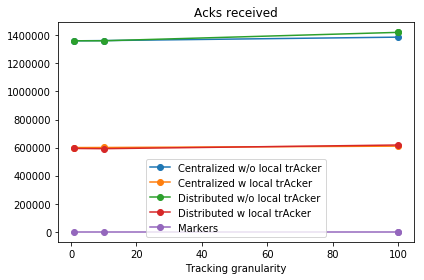

In [5]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['tracking_frequency'], result.acker()['acksReceived'])
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Acks received')
plt.xlabel('Tracking granularity')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


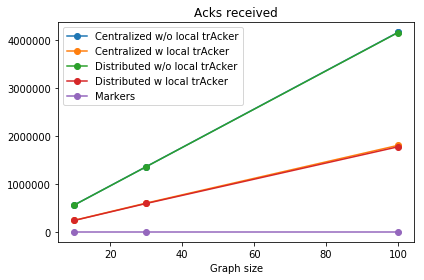

In [6]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['iterations'], result.acker()['acksReceived'])
    for result in results
    if result.vars()['tracking_frequency'] == 10
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Acks received')
plt.xlabel('Graph size')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


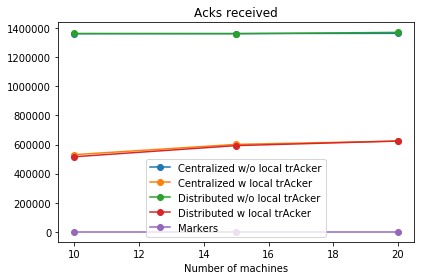

In [7]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['parallelism'], result.acker()['acksReceived'])
    for result in results
    if
        result.vars()['iterations'] == 30
        and result.vars()['tracking_frequency'] == 10
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Acks received')
plt.xlabel('Number of machines')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


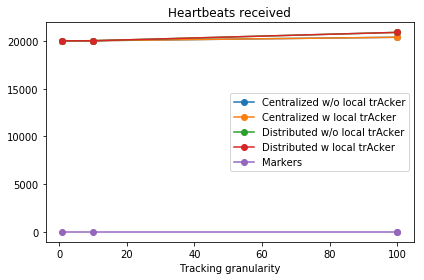

In [8]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['tracking_frequency'], result.acker()['heartbeatsReceived'])
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Heartbeats received')
plt.xlabel('Tracking granularity')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


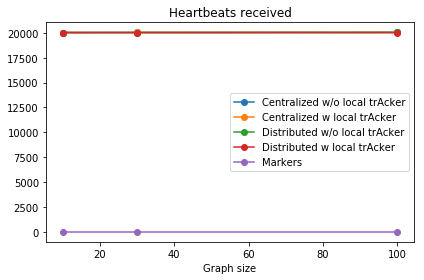

In [9]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['iterations'], result.acker()['heartbeatsReceived'])
    for result in results
    if result.vars()['tracking_frequency'] == 10
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Heartbeats received')
plt.xlabel('Graph size')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


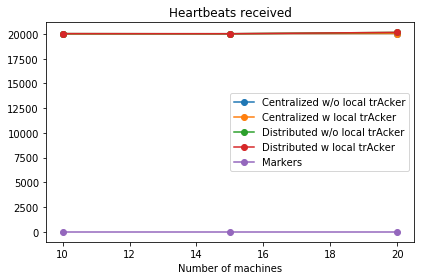

In [10]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['parallelism'], result.acker()['heartbeatsReceived'])
    for result in results
    if
        result.vars()['iterations'] == 30
        and result.vars()['tracking_frequency'] == 10
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Heartbeats received')
plt.xlabel('Number of machines')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


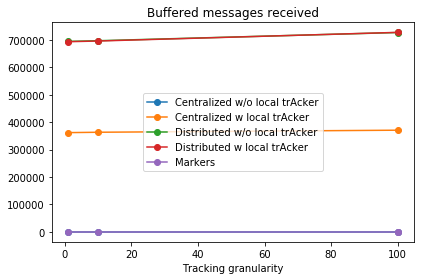

In [11]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['tracking_frequency'], result.acker()['bufferedMessagesHandled'])
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Buffered messages received')
plt.xlabel('Tracking granularity')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


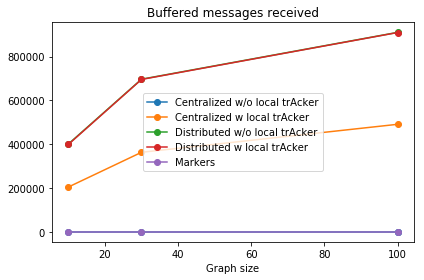

In [12]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['iterations'], result.acker()['bufferedMessagesHandled'])
    for result in results
    if result.vars()['tracking_frequency'] == 10
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Buffered messages received')
plt.xlabel('Graph size')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


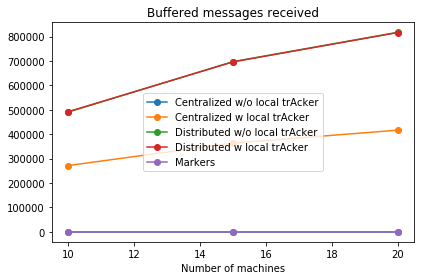

In [13]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['parallelism'], result.acker()['bufferedMessagesHandled'])
    for result in results
    if
        result.vars()['iterations'] == 30
        and result.vars()['tracking_frequency'] == 10
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Buffered messages received')
plt.xlabel('Number of machines')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


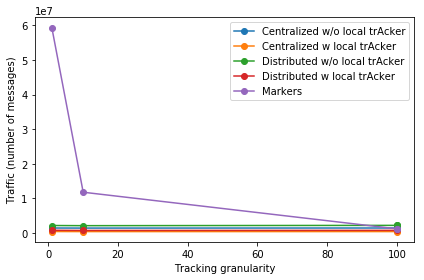

<Figure size 432x288 with 0 Axes>

In [14]:
fig = plt.gcf()
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['tracking_frequency'], result.traffic())
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
])
plt.ylabel('Traffic (number of messages)')
plt.xlabel('Tracking granularity')
plt.show()
plt.draw()
fig.savefig('traffic_by_tracking_frequency.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


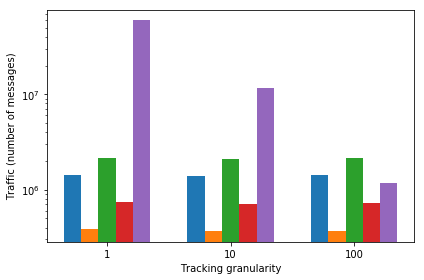

<Figure size 432x288 with 0 Axes>

In [15]:
fig, axs = plot_bars_by_legend({
  legend: {
    result.vars()['tracking_frequency']: result.traffic()
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  }
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
})
axs.get_legend().set_visible(False)
plt.yscale('log')
plt.xlabel('Tracking granularity')
plt.ylabel('Traffic (number of messages)')
plt.show()
plt.draw()
fig.savefig('traffic_by_tracking_frequency_bars.png')

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


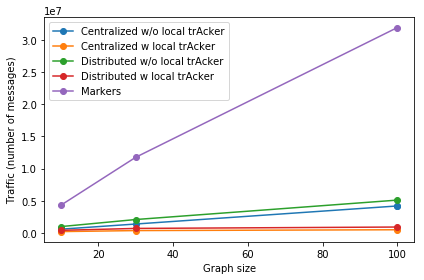

<Figure size 432x288 with 0 Axes>

In [16]:
fig = plt.gcf()
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['iterations'], result.traffic())
    for result in results
    if result.vars()['tracking_frequency'] == 10
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
])
plt.ylabel('Traffic (number of messages)')
plt.xlabel('Graph size')
plt.show()
plt.draw()
fig.savefig('traffic_by_graph_size.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


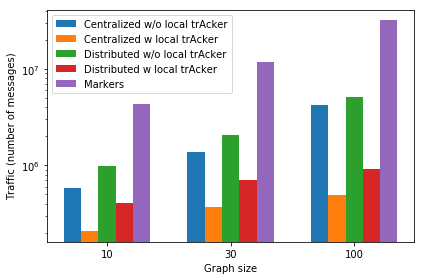

<Figure size 432x288 with 0 Axes>

In [17]:
fig, axs = plot_bars_by_legend({
  legend: {
    result.vars()['iterations']: result.traffic()
    for result in results
    if result.vars()['tracking_frequency'] == 10
        and result.vars()['parallelism'] == 15
  }
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
})
plt.yscale('log')
plt.xlabel('Graph size')
plt.ylabel('Traffic (number of messages)')
plt.show()
plt.draw()
fig.savefig('traffic_by_graph_size_bars.png')

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


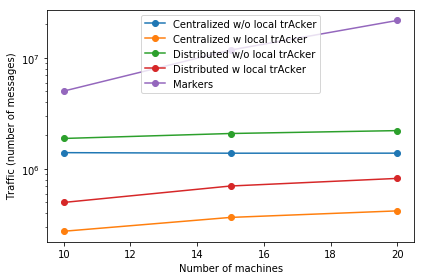

<Figure size 432x288 with 0 Axes>

In [18]:
fig = plt.gcf()
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['parallelism'], result.traffic())
    for result in results
    if
        result.vars()['iterations'] == 30
        and result.vars()['tracking_frequency'] == 10
  ])), marker='o') and legend
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
])
plt.ylabel('Traffic (number of messages)')
plt.xlabel('Number of machines')
plt.show()
plt.draw()
fig.savefig('traffic_by_number_of_machines.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


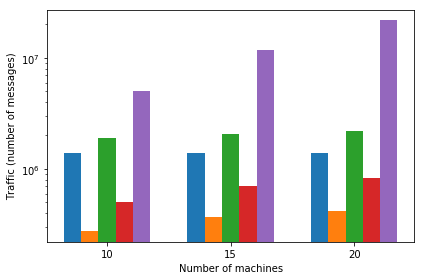

<Figure size 432x288 with 0 Axes>

In [30]:
fig, axs = plot_bars_by_legend({
  legend: {
    result.vars()['parallelism']: result.traffic()
    for result in results
    if
        result.vars()['iterations'] == 30
        and result.vars()['tracking_frequency'] == 10
  }
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
})
axs.get_legend().set_visible(False)
plt.yscale('log')
plt.xlabel('Number of machines')
plt.ylabel('Traffic (number of messages)')
plt.show()
plt.draw()
fig.savefig('traffic_by_number_of_machines_bars.png')

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


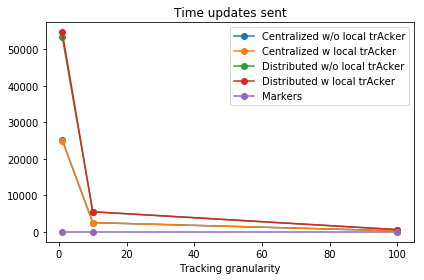

In [20]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['tracking_frequency'], result.min_time_updates_sent())
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Time updates sent')
plt.xlabel('Tracking granularity')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


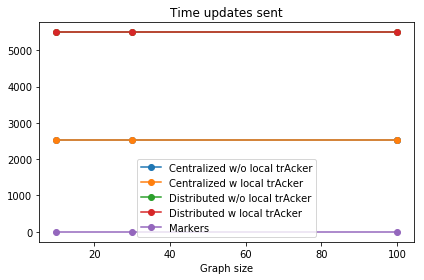

In [21]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['iterations'], result.min_time_updates_sent())
    for result in results
    if result.vars()['tracking_frequency'] == 10
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Time updates sent')
plt.xlabel('Graph size')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


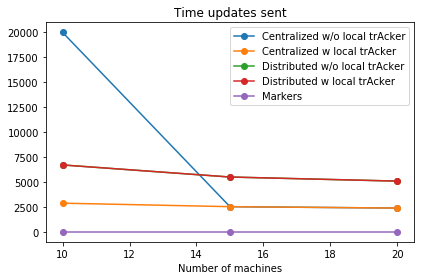

In [22]:
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['parallelism'], result.min_time_updates_sent())
    for result in results
    if
        result.vars()['iterations'] == 30
        and result.vars()['tracking_frequency'] == 10
  ])), marker='o') and legend
  for legend, results in acking_results.items()
])
plt.title('Time updates sent')
plt.xlabel('Number of machines')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


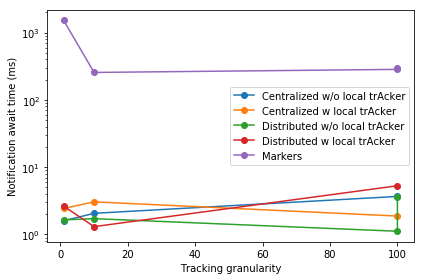

<Figure size 432x288 with 0 Axes>

In [23]:
fig = plt.gcf()
plt.legend([
  plt.plot(*zip(*sorted([
    (
      result.vars()['tracking_frequency'],
      np.median([min(slice) for slice in each_slice(
        result.notification_await_times(),
        result.vars()['tracking_frequency'] * result.vars()['parallelism'],
      )]),
    )
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
])
plt.yscale('log')
plt.xlabel('Tracking granularity')
plt.ylabel('Notification await time (ms)')
plt.show()
plt.draw()
fig.savefig('notification_await_time_by_tracking_frequency.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


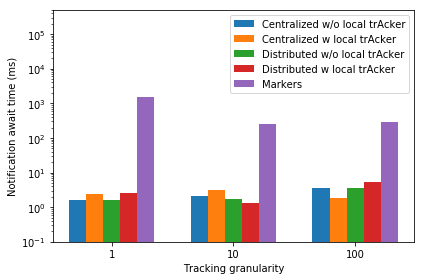

<Figure size 432x288 with 0 Axes>

In [24]:
fig, axs = plot_bars_by_legend({
  legend: {
    result.vars()['tracking_frequency']: np.median([min(slice) for slice in each_slice(
      result.notification_await_times(),
      result.vars()['tracking_frequency'] * result.vars()['parallelism'],
    )])
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  }
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
})
axs.set_ylim([0.1, 5 * 10**5])
# axs.get_legend().set_visible(False)
plt.yscale('log')
plt.xlabel('Tracking granularity')
plt.ylabel('Notification await time (ms)')
plt.show()
plt.draw()
fig.savefig('notification_await_time_by_tracking_frequency_bars.png')

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


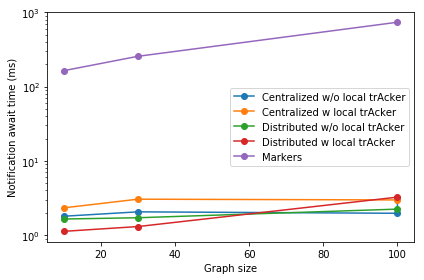

<Figure size 432x288 with 0 Axes>

In [25]:
fig = plt.gcf()
plt.legend([
  plt.plot(*zip(*sorted([
    (
      result.vars()['iterations'],
      np.median([min(slice) for slice in each_slice(
        result.notification_await_times(),
        result.vars()['tracking_frequency'] * result.vars()['parallelism'],
      )]),
    )
    for result in results
    if result.vars()['tracking_frequency'] == 10
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
])
plt.yscale('log')
plt.xlabel('Graph size')
plt.ylabel('Notification await time (ms)')
plt.show()
plt.draw()
fig.savefig('notification_await_time_by_graph_size.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


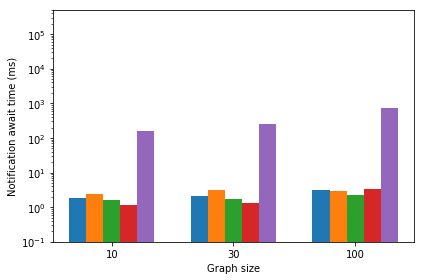

<Figure size 432x288 with 0 Axes>

In [26]:
fig, axs = plot_bars_by_legend({
  legend: {
    result.vars()['iterations']: np.median([min(slice) for slice in each_slice(
      result.notification_await_times(),
      result.vars()['tracking_frequency'] * result.vars()['parallelism'],
    )])
    for result in results
    if result.vars()['tracking_frequency'] == 10
        and result.vars()['parallelism'] == 15
  }
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
})
axs.set_ylim([0.1, 5 * 10**5])
axs.get_legend().set_visible(False)
plt.yscale('log')
plt.xlabel('Graph size')
plt.ylabel('Notification await time (ms)')
plt.show()
plt.draw()
fig.savefig('notification_await_time_by_graph_size_bars.png')

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


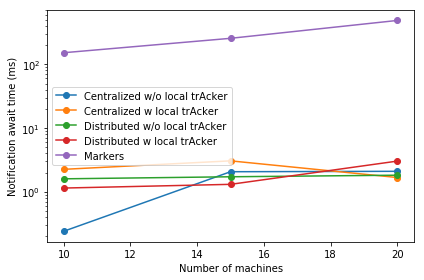

<Figure size 432x288 with 0 Axes>

In [27]:
fig = plt.gcf()
plt.legend([
  plt.plot(*zip(*sorted([
    (
      result.vars()['parallelism'],
      np.median([min(slice) for slice in each_slice(
        result.notification_await_times(),
        result.vars()['tracking_frequency'] * result.vars()['parallelism'],
      )]),
    )
    for result in results
    if
        result.vars()['iterations'] == 30
        and result.vars()['tracking_frequency'] == 10
  ])), marker='o') and legend
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
])
plt.yscale('log')
plt.xlabel('Number of machines')
plt.ylabel('Notification await time (ms)')
plt.show()
plt.draw()
fig.savefig('notification_await_time_by_number_of_machines.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


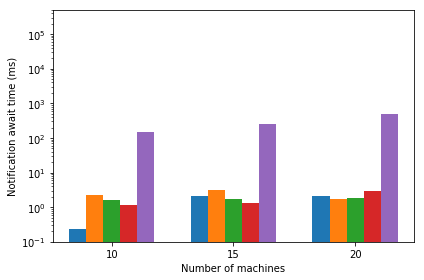

<Figure size 432x288 with 0 Axes>

In [28]:
fig, axs = plot_bars_by_legend({
  legend: {
    result.vars()['parallelism']: np.median([min(slice) for slice in each_slice(
      result.notification_await_times(),
      result.vars()['tracking_frequency'] * result.vars()['parallelism'],
    )])
    for result in results
    if
        result.vars()['iterations'] == 30
        and result.vars()['tracking_frequency'] == 10
  }
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
})
axs.set_ylim([0.1, 5 * 10**5])
axs.get_legend().set_visible(False)
plt.yscale('log')
plt.xlabel('Number of machines')
plt.ylabel('Notification await time (ms)')
plt.show()
plt.draw()
fig.savefig('notification_await_time_by_number_of_machines_bars.png')


In [29]:
{
  legend: {
    result.vars()['parallelism']: np.median([min(slice) for slice in each_slice(
      result.notification_await_times(),
      result.vars()['tracking_frequency'] * result.vars()['parallelism'],
    )])
    for result in results
    if
        result.vars()['iterations'] == 30
        and result.vars()['tracking_frequency'] == 10
  }
  for legend, results in tracking_results.items()
  if legend != 'Disabled'
}


{'Centralized w local trAcker': {10: 2.249391, 15: 3.055685, 20: 1.672717},
 'Centralized w/o local trAcker': {10: 0.2400845, 15: 2.063794, 20: 2.0944785},
 'Distributed w local trAcker': {10: 1.1437235000000001,
  15: 1.308123,
  20: 3.030832},
 'Distributed w/o local trAcker': {10: 1.5965635, 15: 1.71955, 20: 1.82008},
 'Markers': {10: 151.9989295, 15: 255.912183, 20: 488.128972}}